## Import Library

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from wordcloud import WordCloud
import nltk # nltk:Natural Language Toolkit, 자연어 처리에 자주쓰이는 library
# 토큰화(단어 분리), 형태소 분석, 품사 태깅, 감정 분석 등
from nltk.corpus import stopwords # corpus: 말뭉치 (대규모 텍스트 데이터 집합), stopwords: 불용어 (영어, 독일어, 프랑스어, 스페인어 등 주요 유럽 언어 중심으로 제공). 한국어는 konlpy 사용
import spacy # ntlk는 연구용 범용 library(데이터많음/속도느림), spacy는 실무용 library(속도빠름)
from collections import Counter

import string

warnings.filterwarnings(action="ignore")

DATA_PATH = "/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/"

## EDA

### Data overview
> *추가 Feature 설명*  
> *원래 라벨링: 여러 명의 annotator(사람)가 각 댓글에 대해 해당 속성이 있는지 여부를 0 또는 1로 표시함.*  
> *최종 값: 각 속성에 대해 모든 annotator의 평균값을 사용 → 결과적으로 0~1 사이의 연속값이 됨.*  

* train  
  id: 그냥 넘버링  
  target: 댓글 공격성 (if toxicity >= 0.5 else 0 적용전)  
  comment_text: 대상 댓글
    
  *추가 Feature-세부공격성*  
  severe_toxitiy: 극단적 공격성 정도 [0,1]  
  obscene: 성적 비하 정도 [0,1]  
  identity_attack: 정체성(성별,종교,인종 등) 공격 정도 [0,1]  
  insult: 일반적 모욕성 정도 [0,1]  
  threat: 위해,위협 정도 [0,1]  
  sexual_explicit: 성적인 묘사 정도 [0,1]
    
  *추가 Feature-identity*  
  asian: 아시아인 언급여부  
  atheist: 무신론자 언급여부  
  bisexual: 양성애자 언급여부  
  black: 흑인 언급여부  
  buddhist: 불교신자 언급여부  
  christian: 기독교인 언급여부  
  female: 여성 언급여부  
  heterosexual: 이성애자 언급여부  
  hindu: 힌두교신자 언급여부  
  homosexual_gay_or_lesbian: 게이,레즈 언급여부  
  intellectual_or_learning_disability: 지적,학습장애 언급여부  
  jewish: 유대인 언급여부  
  latino: 중남미출신 언급여부  
  male: 남성 언급여부  
  muslim: 이슬람교인 언급여부  
  other disability: 지적,신체적 장애 외 기타장애 언급여부  
  other_gender: 남성,여성,트렌스젠더 외 다른 성별 언급여부  
  other_race_or_ethnicity: 흑인,백인,라틴,아시아인,아메리카원주민 외 다른 인종 언급여부  
  other_religion: 기독교,불교,유대교,이슬람교,힌두교 외 다른 종교 언급여부  
  other_sexual_orientation: 이성애자,동성애자,양성애자,게이,레즈 외 다른 성적정체성 언급여부  
  physical_disability: 신체적 장애 언급여부  
  psychiatric_or_mental_illness: 정신적 질병 언급여부  
  transgender: 트렌스젠더 언급여부  
  white: 백인 언급여부
    
  *추가 Feature-meta data*  
  created_date: 댓글 작성날짜  
  publication_id: 댓글달린 기사의 출판물 ID  
  parent_id: 댓글이 답글인 경우 부모 댓글 ID  
  article_id: 댓글이 달린 기사의 ID  
  rating: 댓글 공개 혹은 차단 여부 ['rejected', 'approved']    
  funny: 재밌어요 반응수  
  wow: 놀라워요 반응수  
  sad: 슬퍼요 반응수  
  likes: 좋아요 반응수  
  disagree: 동의하지 않아요 반응수  
  identity_annotator_count: identity 관련 feature 라벨링 참여인 수  
  toxicity_annotator_count: toxicity 관련 feature 라벨링 참여인 수

* test  
  id: 그냥 넘버링    
  comment_text: 대상 댓글

In [2]:
df_train = pd.read_csv(DATA_PATH+"train.csv")
df_test = pd.read_csv(DATA_PATH+"test.csv")
df_sample = pd.read_csv(DATA_PATH+"sample_submission.csv")

In [3]:
'''
all_data.csv
│
├── train.csv                     # 학습 데이터 (1.8M행)
└── test.csv                      # 채점용 데이터 (0.6M행)
     ├── test_public_expanded.csv   # test의 20% (Public LB용)
     └── test_private_expanded.csv  # test의 80% (Private LB용)

df_all = pd.read_csv(DATA_PATH+"all_data.csv")
df_identity = pd.read_csv(DATA_PATH+"identity_individual_annotations.csv")
df_toxicity = pd.read_csv(DATA_PATH+"toxicity_individual_annotations.csv")
df_test_private_expanded = pd.read_csv(DATA_PATH+"test_private_expanded.csv")
df_test_public_expanded = pd.read_csv(DATA_PATH+"test_public_expanded.csv")
'''

'\nall_data.csv\n│\n├── train.csv                     # 학습 데이터 (1.8M행)\n└── test.csv                      # 채점용 데이터 (0.6M행)\n     ├── test_public_expanded.csv   # test의 20% (Public LB용)\n     └── test_private_expanded.csv  # test의 80% (Private LB용)\n\ndf_all = pd.read_csv(DATA_PATH+"all_data.csv")\ndf_identity = pd.read_csv(DATA_PATH+"identity_individual_annotations.csv")\ndf_toxicity = pd.read_csv(DATA_PATH+"toxicity_individual_annotations.csv")\ndf_test_private_expanded = pd.read_csv(DATA_PATH+"test_private_expanded.csv")\ndf_test_public_expanded = pd.read_csv(DATA_PATH+"test_public_expanded.csv")\n'

In [4]:
df_train['rating'].unique()

array(['rejected', 'approved'], dtype=object)

In [5]:
df_train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [6]:
pd.set_option("display.max_colwidth", None) # 텍스트 데이터 생략 없이 전체 표기.
'''
여러 컬럼은 전달 시 dataframe 2차원이라서 두겹으로 작성.
단일 컬럼은 series라서 한겹.
'''
df_train.sample(30)[['id', 'target', 'comment_text']]

,id,target,comment_text
569707,939424,0.000000,"I like REIT's ...............makes me fell like an anonymous landlord and therefor invisible.\nYou don't have to put up ""For Sale"" signs and deal with offers just hit the click button to sell or call your broker................in the meantime collect the div."
944087,5273585,0.166667,"What a joke. Would Trustin ever target CHINA? I think not. What about all those ipods or womens fashion that produced by little people in Asia, no problem there right?"
121981,391167,0.000000,This coming from a presidential candidate who let a third rate political correspondent (Candy Crowley) make him look like a child. This from a man who has always made his money by picking the bones of business in bankruptcy. Romney built his empire from illegal associations with bankruptcy professionals who regularly engaged in illegal activities in courtrooms across the country. This is a man were going to listen to about anything? He is just dissapointed that he couldn't make any money off of Trump's miseries.\n\nI also admire Vladimir Putin he is a real leader. It is just too bad that he is a communist.\n\nHugs & Kisses
452585,798749,0.166667,"It's clear many here fail to grasp the enormity of the election of the Russian stooge, Donald Trump. All week we have witnessed the amazing spectacle of the president-elect deriding the credibility of the US intelligence establishment in the interest of defending Russia against the charge of influencing the election. James Woolsey abruptly quit the Trump transition team last night, explaining to CNN that he did not want to ""fly under false colors."" While Woolsey may have been referring simply to his discomfort at being presented as a senior advisor when in actuality he was being shut out of the process, his choice of words was suggestive.\n\nIf Trump released his tax returns it might end speculation of his financial entanglements with Russian oligarchs. This is the man who for years demanded President Obama's birth certificate to ""prove"" the president's legitimacy. The terrible irony of it all."
50697,303829,0.200000,"Wow, up to a hectare of land! Big enough for a dog. So generous, Mr. Gazillionaire-I-Collect-Stradivariuses for my pal's House of Music in St. Petersburg...! I know: why don't you move your entire government to this free land of yours, next to the 414 volcanoes of Kamchatka, and the three military bases (good in case of an evacuation emergency), so you can be a little further away from the excitement along the Western borders, and in the city streets of Moscow. It's time to loot, sorry, I meant govern, the Russian Federation from the shores of its Pacific coastline. Let the people of the Far East enjoy the pleasure of your company -- sorry, I meant your unpredictable fun. Oh, and please remember to take that 300 000 strong Gestapo force of yours with you. And the bikers. The fresh air and radioactive water will do them a world of good!"
1363839,5783330,0.000000,I wonder how many of those football players personally live with Jay Madden or other coaches as their parents probably still live in a different city.
1798285,6325073,0.166667,"Herr, thank-you for your respectful reply and explanation.\n\nI'm not looking to point a finger of culpability. I want look to see what lessons can be learned from this tragedy. We won't be able to do this by simply pointing a finger or shutting down a discussion. Still, I wonder if having the healthcare benefits that were denied could have prevented this tragedy. If that is true then don't you think to deny them may, indeed, be reckless? Could the writer be trying to raise awareness of this? \n\nOne of the issues these kinds of tragedies raise is how we, as followers of the Prince of Peace, are called to respond to those, who perpetrate a monstrous act. Despite the true horror of their action, I can't just throw them aside. That would contradict much of what I believe Christ's witness teaches us and how we are called 

In [7]:
df_train.shape

(1804874, 45)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [9]:
df_train['comment_text'].apply(type).value_counts()

comment_text
<class 'str'>      1804871
<class 'float'>          3
Name: count, dtype: int64

In [10]:
def missing_count(df: pd.DataFrame) -> pd.Series:
    """
    각 컬럼별 결측치 개수를 반환하는 함수
    df.count() 기반으로 계산
    """
    n_rows = len(df)
    return n_rows - df.count()
    # df.count()는 non-null만 세기에 isnull.sum()보다 빠름

missing = missing_count(df_train)
print(missing)

id                                           0
target                                       0
comment_text                                 3
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

In [11]:
# 문자형 unique 확인
df_train.describe(include="object").T

,count,unique,top,freq
comment_text,1804871,1780822,Well said.,184
created_date,1804874,1804362,2015-10-13 18:40:35.757707+00,4
rating,1804874,2,approved,1684758


In [12]:
# 수치형 
df_train.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
id,1804874.0,3738433.79,2445186.76,59848.0,796975.25,5223774.5,5769854.50,6334010.00
target,1804874.0,0.10,0.20,0.0,0.00,0.0,0.17,1.00
severe_toxicity,1804874.0,0.00,0.02,0.0,0.00,0.0,0.00,1.00
obscene,1804874.0,0.01,0.06,0.0,0.00,0.0,0.00,1.00
identity_attack,1804874.0,0.02,0.08,0.0,0.00,0.0,0.00,1.00
insult,1804874.0,0.08,0.18,0.0,0.00,0.0,0.09,1.00
threat,1804874.0,0.01,0.05,0.0,0.00,0.0,0.00,1.00
asian,405130.0,0.01,0.09,0.0,0.00,0.0,0.00,1.00
atheist,405130.0,0.00,0.05,0.0,0.00,0.0,0.00,1.00
bisexual,405130.0,0.00,0.03,0.0,0.00,0.0,0.00,1.00


In [13]:
df_test.head()

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\nDoes this apply to President Trump too?
1,7097321,This is malfeasance by the Administrator and the Board. They are wasting our money!
2,7097322,"@Rmiller101 - Spoken like a true elitist. But look out bud. The re-awakening in Europe, Brexit and now the Trump victory are just the beginning. The unwashed masses are coming for you and your ilk…."
3,7097323,"Paul: Thank you for your kind words. I do, indeed, have strong beliefs and don't hide them. They are based on both facts and values. I think the question of ""bias"" and ""prejudice"" comes into play when we're discussing beliefs and attitudes based on values. One of our poster friends, for example, often comments that being ""intolerant"" of a bias, for example, is, in itself, a bias. This is, IMO, where the concept of ""irratonal antipathy"" is important. If I dislike neo-Nazis because of their views on race, my antipathy is based on fact (knowledge of their views) and values (my belief that condemning others because of their race/religion is WRONG). Were I to, instead, dislike all Germans, that, IMO, would represent a bias...an irrational antipathy...since not all Germans condemn others because of their race/religion. I discuss the ""bias"" question in another response to you....\n\nIt's an interesting topic and I'd enjoy discussing it w/you sometime. Give me a call. Gary Crum"
4,7097324,Sorry you missed high school. Eisenhower sent troops to Vietnam after the French withdrew in 1954 and before that America was providing 50% of the cost of that war. WWI & WWII were won by Democrat Presidents and the last win a Republican had was 1865 but the did surrender in Korea and Vietnam and fail to win in desert Storm or these two wars.


In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97320 entries, 0 to 97319
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            97320 non-null  int64 
 1   comment_text  97320 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [15]:
df_test.shape

(97320, 2)

### Visualization

### count check
* 데이터 불균형 심함
* 0이 아니라 1 맞추는 것에 집중
* toxicity가 있는 문장들의 경우 주기성이 보임. 점수 마킹 후 정규화의 패턴으로 추측

In [16]:
df_train['target_bin'] = df_train['target'].map(
    lambda x : 1 if x>=0.5 else 0
) # 임의로 설정해서 toxicity와 아닌 문장의 비율을 확인

df_train[['target','target_bin','comment_text']].sample(3)

,target,target_bin,comment_text
1683781,0.000000,0,"Putting their own personal agenda first, ahead of what?"
986534,0.833333,1,New players with the same dumb ideas and economic incompetence as 20 years ago. Nothing has changed. Same old NDP with a twist of Green social engineering to really screw things up.
1530211,0.600000,1,He needs to put a cap on white racist terrorists who are responsible for almost all of domestic attacks on civilians in America since 9-11. Check the stats.


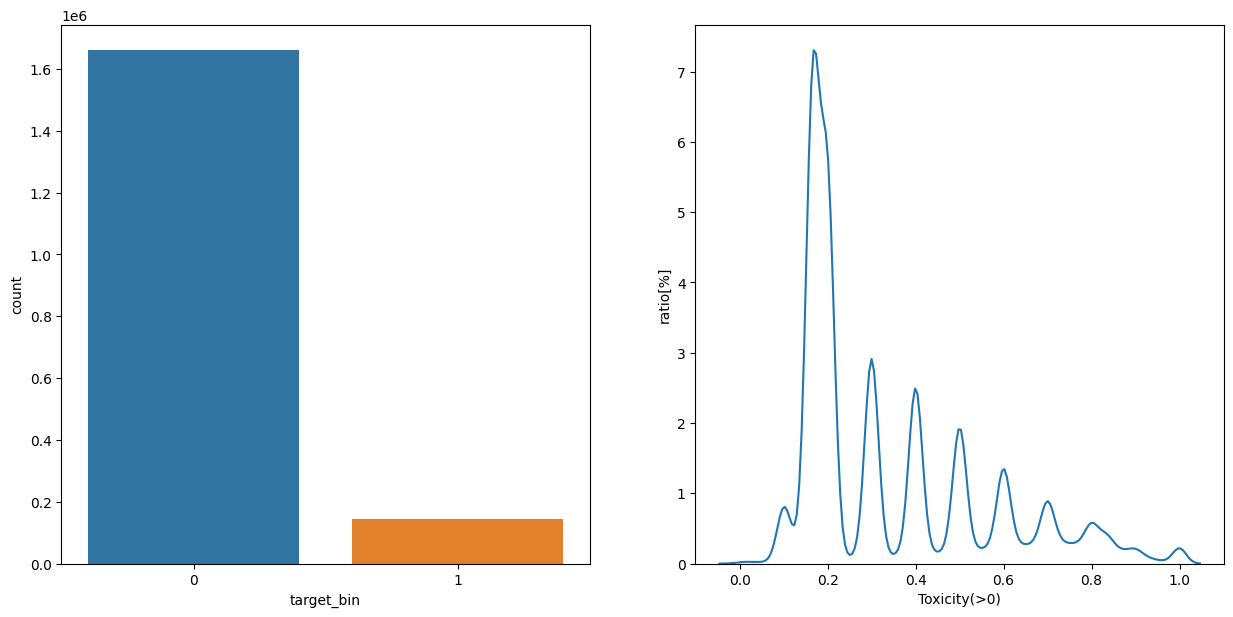

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
sns.countplot(x='target_bin', data=df_train, ax=ax1)
sns.kdeplot(x='target', data=df_train[df_train['target'] > 0], ax=ax2)
ax2.set_ylabel("ratio[%]")
ax2.set_xlabel("Toxicity(>0)")
plt.show()

### 텍스트 시각화: 워드클라우드
* 전체적으로 그리고 insult에도 특이하게 trump가 크게 보임. 당시 시기가 미국 대선이었나?  
  *2016년 11월 미국 대통령 선거: 트럼프 vs 클린턴*  
  *데이터는 2017년 수집*  
* like, want, tell, say 같이 대화체 verb도 주로 보이고
* 제대로 분석하려면 verb를 제껴야 할거 같은데: 모든 verb를 삭제하는 건 'attack'같은 유의미 verb까지 삭제  
  *따라서 frequency 기반으로 일반 verb 추출해서 stop_words에 포함*

In [33]:
stop_words = stopwords.words("english")
# 필요에 따라 stop_words.append(), stop_words.remove() 가능

In [34]:
print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

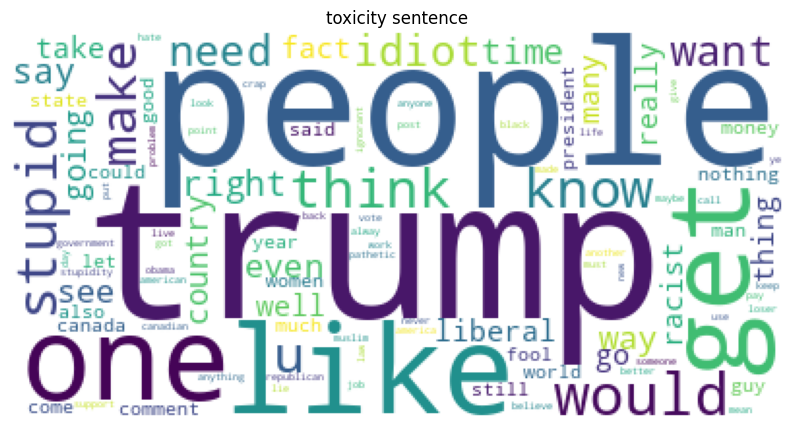

In [20]:
# df.loc[행조건, 열선택]
# 반환값은 Series(index, dtype까지 존재) -> tolist()로 list로 변환
# df_train.loc[df_train['target']>0, 'comment_text'].tolist()
toxicity_lists = df_train[df_train['target']>0.5]['comment_text'].tolist()
toxicities = " ".join(toxicity_lists).lower() # 문자열 method = "구분자".join(리스트)
# Dataframe.join과는 다름. df1.join(df2, how="left", on="key")

wc_toxic = WordCloud(
    max_font_size=100, 
    max_words=100, 
    background_color='white', 
    stopwords=stop_words
).generate(toxicities)

plt.figure(figsize=(10,10))
plt.imshow(wc_toxic)
plt.axis("off")
plt.title("toxicity sentence")
plt.show()


In [21]:
stop_words = stop_words.append('would')

In [22]:
def wordcloud(feature, df, target_text='comment_text', stopwords=stop_words, threshold=0.5, grid_ax=None):
    lists = df[df[feature]>threshold][target_text].tolist()
    texts = " ".join(lists).lower()

    wc = WordCloud(
        width=400, height=300, # WordCloud()는 기본적으로 (400, 200)의 가로로 긴 직사각형 크기
        max_font_size=100, 
        max_words=80, 
        background_color='white', 
        stopwords=stopwords
    ).generate(texts)

    # grid_ax가 주어졌다면 해당 축에 그림
    if grid_ax is not None:
        ax = grid_ax
    else:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    ax.imshow(wc)
    ax.axis("off")
    ax.set_title(f"{feature} sentence")

    if grid_ax is None:
        plt.show()

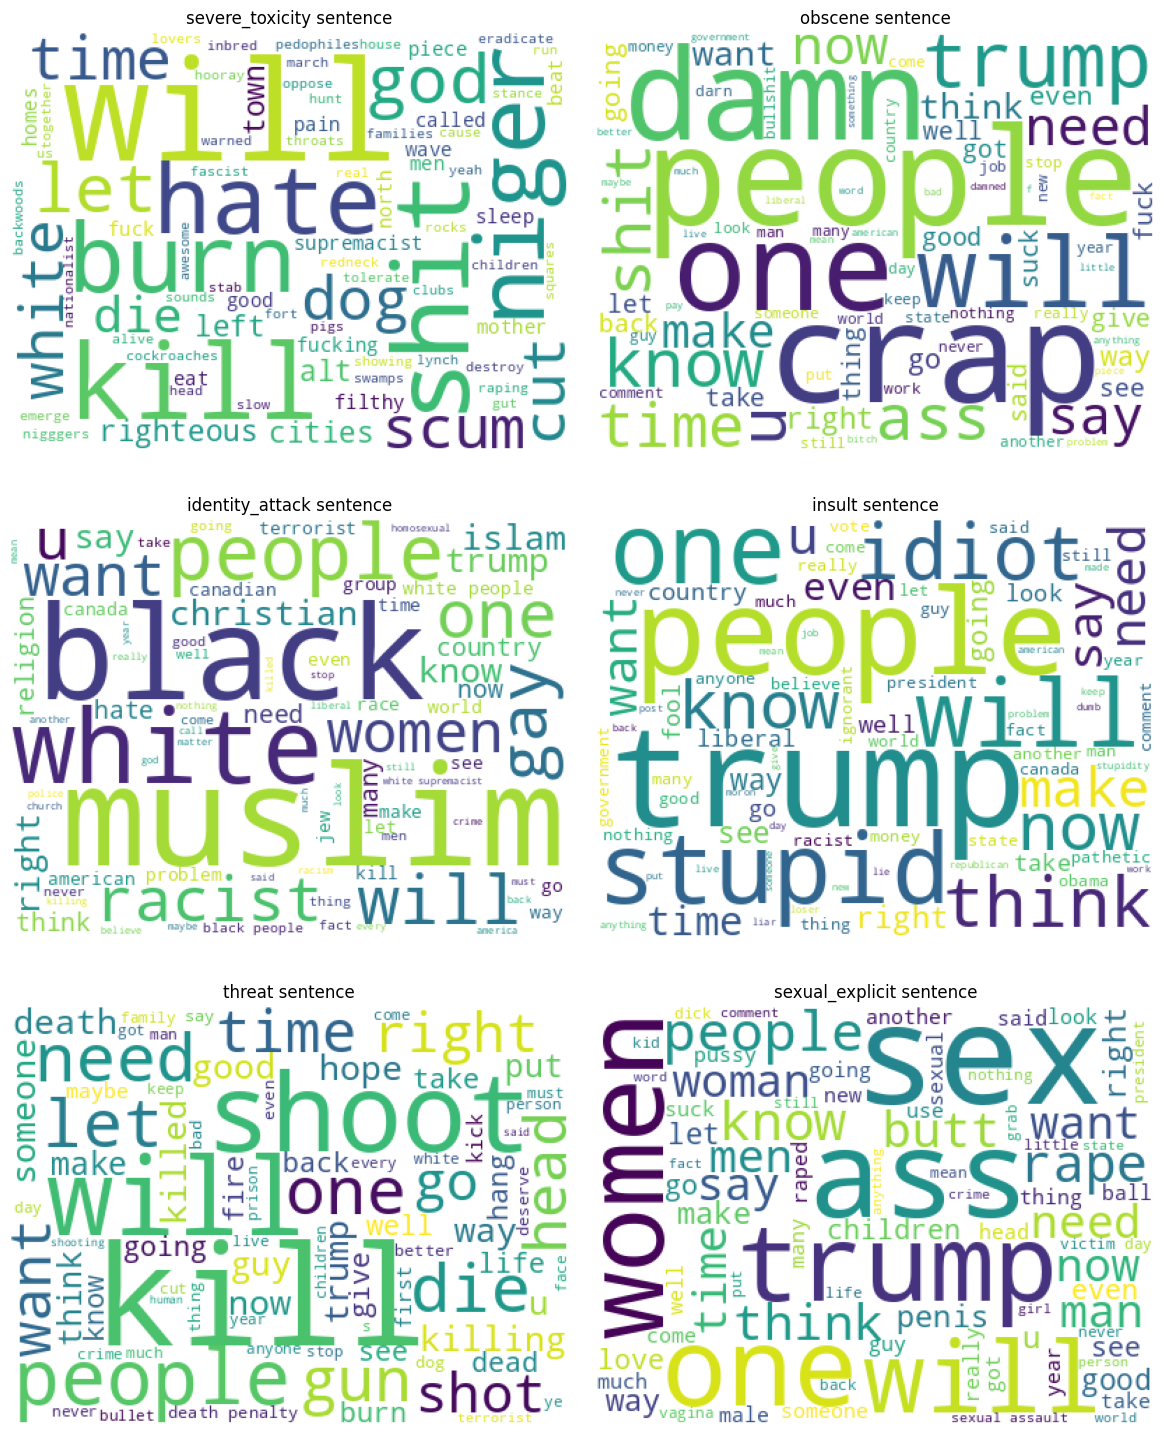

In [23]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
for i, feature in enumerate(features):
    ax = axes.flat[i]
    wordcloud(feature, df_train, grid_ax=ax)

plt.tight_layout(pad=2.0)
plt.show()

In [24]:
# !python -m spacy download en_core_web_md

In [25]:
# 소형(sm) langauge model(영어) 로드 (LLM은 Large language model)
# 언어모델: 주어진 텍스트에서 다음 단어를 예측하거나 문장의 구조와 의미를 파악하는 모델
lm = spacy.load("en_core_web_sm")

n = 100000
texts = df_train['comment_text'].sample(n).apply(str).tolist()  # 샘플링도 하나의 방법

# 모든 동사 lemma(원형) 추출
verbs = []
for doc in lm.pipe(texts, batch_size=5000, disable=["ner", "parser"]): # slm로 texts를 batch(한꺼번에)처리. 이때 parser, ner는 끄고 진행
    # 처리결과는 Doc 객체: 한 문장(혹은 텍스트 전체)을 분석한 결과를 담는 컨테이너
    verbs.extend([token.lemma_.lower() for token in doc if token.pos_ == "VERB"])
    # append 대신 extend 사용 -> 다중 리스트를 풀어서 삽입. 통재로 리스트 째로 삽입 X

# 빈도 계산
verb_counts = Counter(verbs)
verb_df = pd.DataFrame(verb_counts.most_common(100), columns=["verb", "count"])

In [31]:
print(verb_df.head(50))

          verb  count
0          get  17419
1           go  14226
2         make  14006
3          say  12563
4        think  10835
5         know  10653
6          see   9309
7         take   8783
8         need   8223
9         want   8073
10         pay   7058
11        come   6617
12         use   6406
13        give   6339
14          do   5511
15        work   5363
16        look   5199
17         try   4663
18         let   4206
19        keep   4131
20        call   4121
21        find   4116
22     believe   4010
23        seem   3995
24        tell   3979
25        live   3757
26        mean   3734
27      happen   3515
28        read   3515
29         put   3383
30        vote   3197
31       leave   3194
32       agree   3051
33         run   2917
34       start   2917
35        stop   2881
36     support   2875
37        show   2795
38        help   2647
39        like   2639
40       allow   2619
41         ask   2600
42        lose   2562
43      become   2551
44     inc

In [39]:
# 상위 50개 중 일반동사만 골라서 stop_words에 포함
common_verbs_stoplist = [
    "get","go","make","say","think","know","see","take","need","want",
    "come","use","give","do","work","look","try","let","keep","call",
    "find","seem","tell","mean","happen","put","show","help","start",
    "stop","allow","ask","include","feel","write","buy","live","change",
    "understand","believe","become","leave", "will"
]

# like 처럼 결합시 don't like로 toxicity가 될 수 있는 단어는 주의

In [40]:
# stop_words.extend(verb_df['verb'][:20].tolist())
stop_words.extend(common_verbs_stoplist)

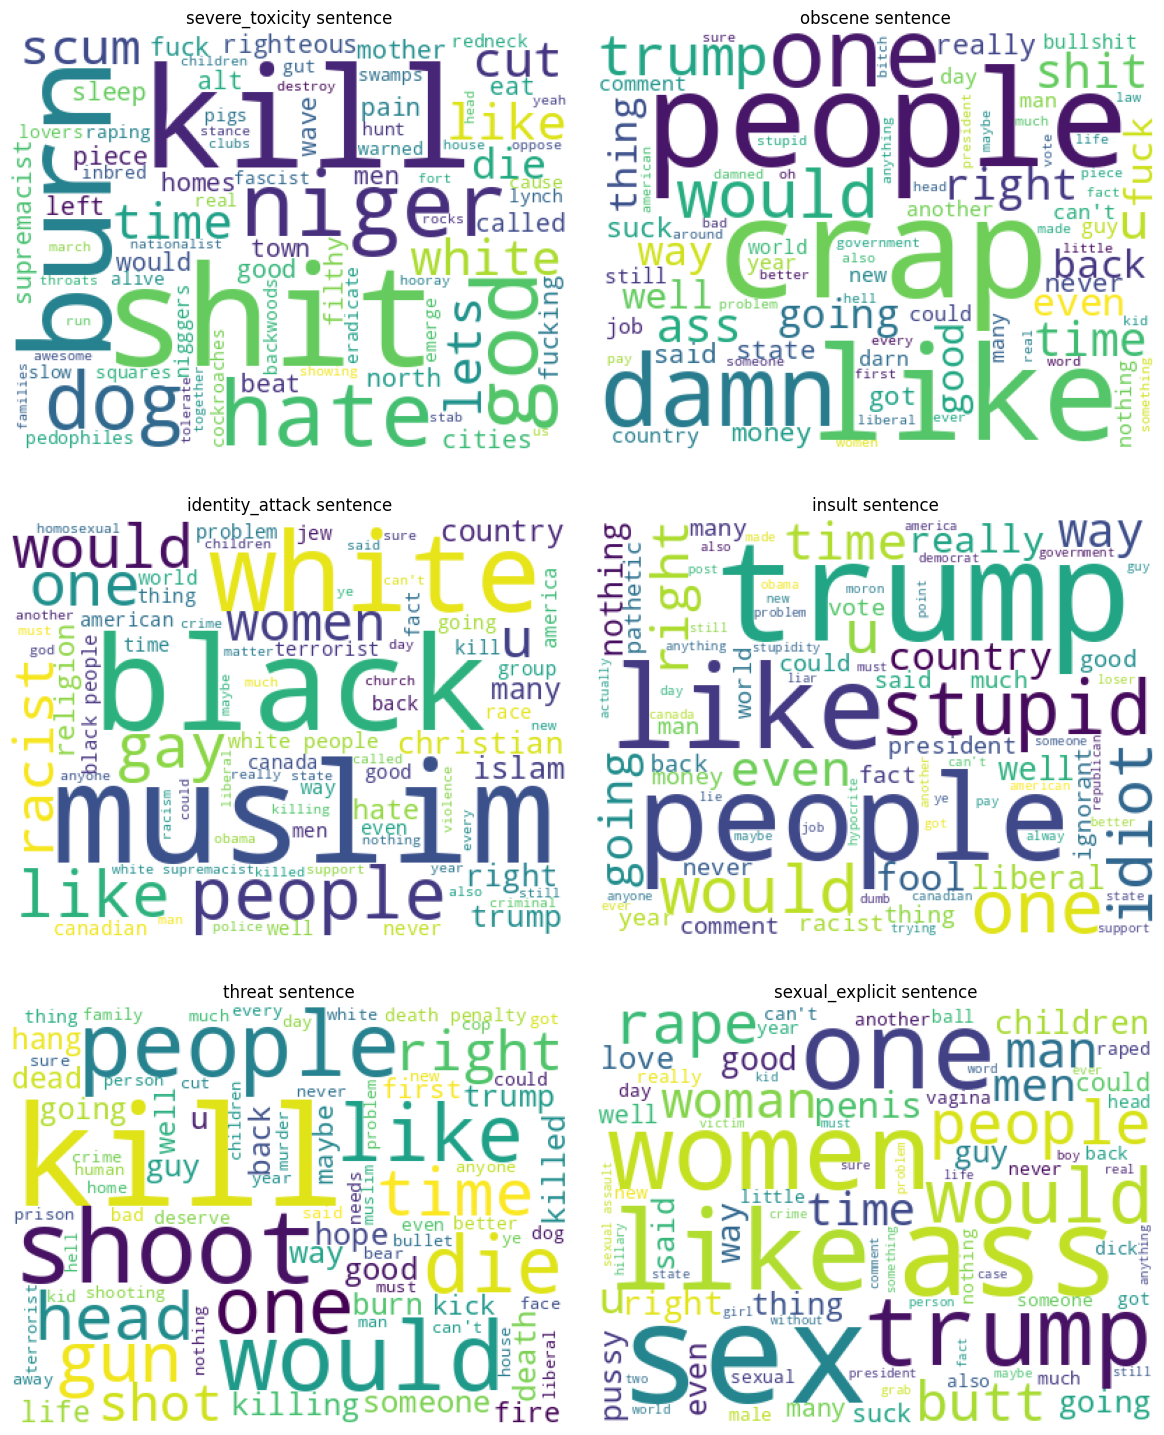

In [43]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
for i, feature in enumerate(features):
    ax = axes.flat[i]
    wordcloud(feature, df_train, grid_ax=ax, stopwords=stop_words)

plt.tight_layout(pad=2.0)
plt.show()

### Text Statistics
* 한 댓글당 단어는 20개 정도가 보통이고 많으면 최대 200개 단어까지도 보임  
  → Transformer, LSTM 입력시 max_len는 around 200 token 
* stopwords는 그중 절반정도의 추세. 보통 10개 정도에 많으면 100개.  
  의미있는 단어는 50%씩 있다고 보면 될 거 같다.  
  → 추가 feature(stopword ratio feature): 언어 공격성 지표, toxic발언은 stopword 비중 낮고 감정/형용사 높음
* 단어는 보통 5글자정도

In [44]:
# Number of words in each sentences
df_train["num_words"] = df_train['comment_text'].apply(
    lambda sen:len(str(sen).split())
)
# str(): 처리해야 혹시모를 숫자나 이상한 문자 안전처리 가능
# split(" "): 이건 정확하게 space 1칸짜리만 분할
# split(): 이건 (2칸이든 1칸이든 탭이든 개행이든) 모든 공백기준으로 분할
df_test["num_words"] = df_test['comment_text'].apply(
    lambda sen:len(str(sen).split())
)

# Number of stop_words in each sentences
df_train["num_stopwords"] = df_train['comment_text'].apply(
    lambda sen:len([word for word in str(sen).lower().split() if word in stop_words])
)
df_test["num_stopwords"] = df_test['comment_text'].apply(
    lambda sen:len([word for word in str(sen).lower().split() if word in stop_words])
)

df_train["avg_word_len"] = df_train['comment_text'].apply(
    # lambda sen:sum(len(word) for word in str(sen).split())/len(str(sen).split())
    lambda sen:np.mean([len(word) for word in str(sen).split()])
)
df_test["avg_word_len"] = df_test['comment_text'].apply(
    lambda sen:np.mean([len(word) for word in str(sen).split()])
)

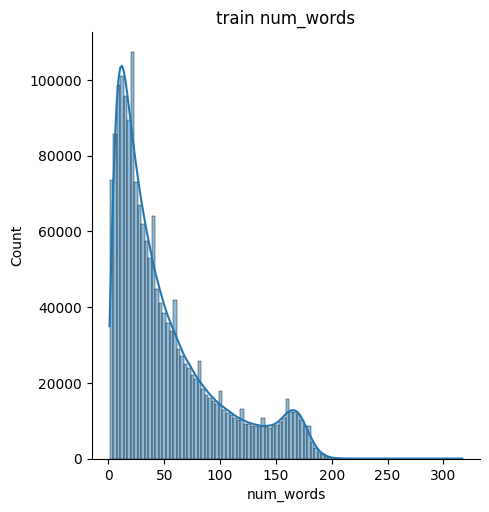

In [56]:
sns.displot(df_train['num_words'], bins=100, kde=True)
plt.title('train num_words')
plt.show()

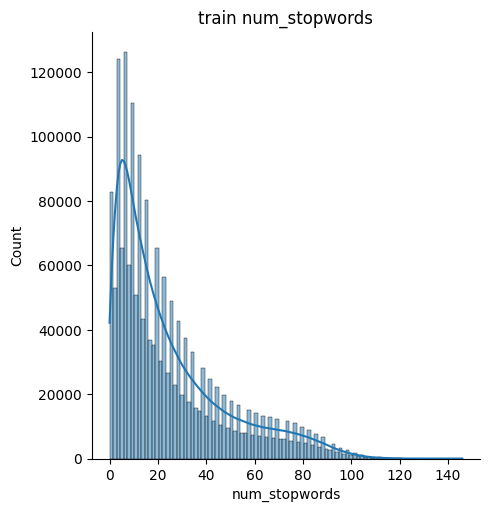

In [57]:
sns.displot(df_train['num_stopwords'], bins=100, kde=True)
plt.title('train num_stopwords')
plt.show()

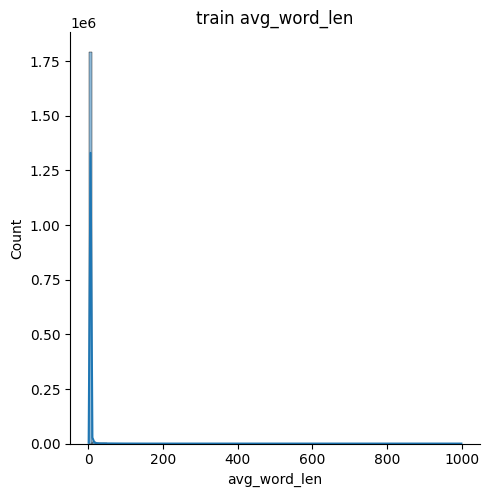

In [58]:
sns.displot(df_train['avg_word_len'], bins=100, kde=True)
plt.title('train avg_word_len')
plt.show()

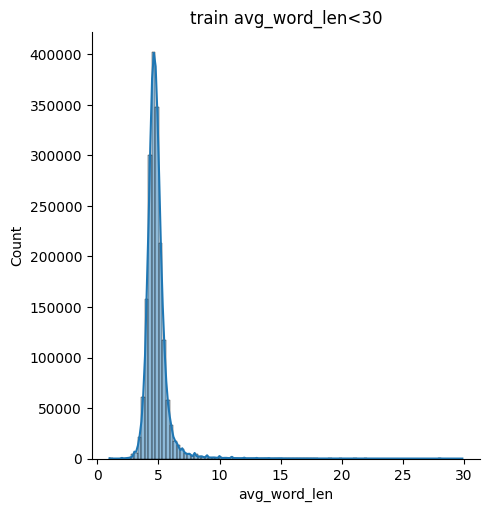

In [60]:
sns.displot(df_train[df_train['avg_word_len']<30]['avg_word_len'], bins=100, kde=True)
# plt.xlim(0,50)
plt.title('train avg_word_len<30')
plt.show()

In [62]:
df_train['stop_words_ratio'] = df_train['num_stopwords']/df_train['num_words']
df_test['stop_words_ratio'] = df_test['num_stopwords']/df_test['num_words']

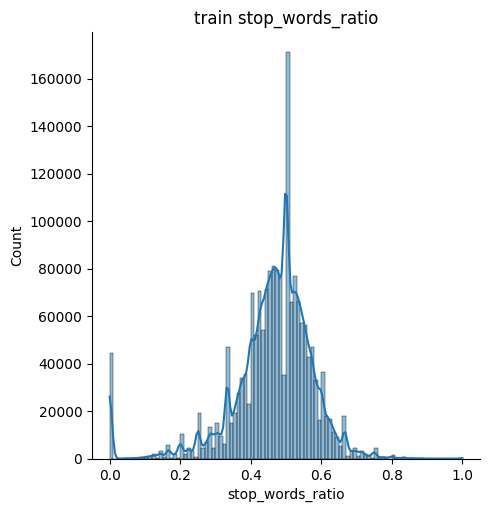

In [63]:
sns.displot(df_train['stop_words_ratio'], bins=100, kde=True)
plt.title('train stop_words_ratio')
plt.show()

In [66]:
df_train.to_csv("/kaggle/working/train_with_stopwordratio.csv", index=False)
df_test.to_csv("/kaggle/working/test_with_stopwordratio.csv", index=False)